In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
from numpy.fft import fftshift,ifft
from scipy.signal import stft, windows

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dataset_path = 'G:/MRM_0.5/'

train_data_path = dataset_path + 'train/'
test_data_path = dataset_path + 'test/'

# pol_type = 'HH'

In [3]:
def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
def rcs(echo):
    return 4*np.pi*np.abs(echo)**2

def normalize(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix
    
def awgn2(signal, snr):
    def add_noise_to_signal(signal, snr):
        # Calculate signal power and convert SNR to linear scale
        signal_power = np.mean(np.abs(signal)**2)
        snr_linear = 10**(snr / 10)
        
        # Calculate noise power and generate complex noise
        noise_power = signal_power / snr_linear
        noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
        noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
        noise = noise_real + 1j * noise_imag
        
        # Add noise to the signal
        signal_with_noise = signal + noise
        
        return signal_with_noise
    
    if signal.ndim == 1:
        # If the input is a single row (1D array)
        return add_noise_to_signal(signal, snr)
    elif signal.ndim == 2:
        # If the input is a matrix (2D array), process each row
        noisy_signals = np.array([add_noise_to_signal(row, snr) for row in signal])
        return noisy_signals
    else:
        raise ValueError("Input signal must be a 1D or 2D array")

def awgn1(signal, snr):
    
    # Calculate signal power and convert SNR to linear scale
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr / 10)
    
    # Calculate noise power and generate complex noise
    noise_power = signal_power / snr_linear
    noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise = noise_real + 1j * noise_imag
    
    # Add noise to the signal
    signal_with_noise = signal + noise
    
    return signal_with_noise

def STFT(st,nfft):
    winlen = 64
    _, _, Zxx = stft(st, fs=1024, window = windows.hamming(winlen), nperseg=winlen, nfft=nfft ,noverlap=winlen-1, boundary='zeros', return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0) 

def pad_hrrp(matrix, target_length):
    if target_length is None:
        return matrix
    else:
        rows, cols = matrix.shape 
        padded_matrix = np.zeros((target_length, cols),dtype=np.complex128)
        padded_matrix[:rows, :] = matrix
        return padded_matrix

def image_hrrp(hrrp, pad_size):
    if pad_size is None:
        pad_size = 201
    hrrp = pad_hrrp(hrrp,pad_size)
    hrrp = fftshift(ifft(hrrp,axis = 0),axes=0)
    hrrp = np.log10(np.abs(hrrp))  
    hrrp = normalize(hrrp)
    # 截断
    # hrrp = hrrp[int(pad_size/4): int(3*pad_size/4), :]
    hrrp = hrrp[75: 125, :]
    return hrrp

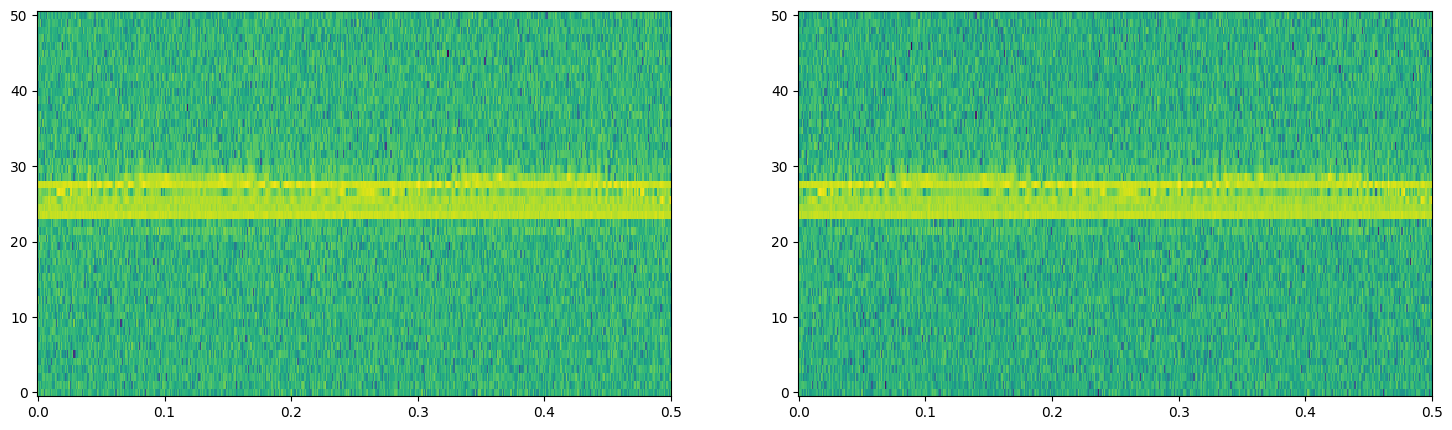

In [4]:
instance = load_pkl(train_data_path + '0/0.pkl')
hrrp1 = image_hrrp(awgn1(instance['hrrp']['VH'], snr=0), pad_size = None)
hrrp2 = image_hrrp(awgn2(instance['hrrp']['VH'], snr=0), pad_size = None)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].pcolormesh(np.linspace(0,0.5,512),np.linspace(0,50,50),hrrp1)
axes[1].pcolormesh(np.linspace(0,0.5,512),np.linspace(0,50,50),hrrp2)

# Function of Load data

In [5]:
# def data processing here.
def preprocessing(data, snr, pad_size):
    polar_type = 'HH'

    # extract rcs
    E = awgn2(data['echo'][polar_type],snr=snr)
    rcs_data = normalize(rcs(E))

    # processing echo
    TFR = STFT(E,nfft = 128)
    TFR = normalize(np.abs(TFR)[:,:-1])

    # extract hrrp
    hrrp = awgn2(data['hrrp'][polar_type], snr=snr)
    hrrp = image_hrrp(hrrp, pad_size = pad_size)

    # unify data type
    rcs_data = torch.tensor(rcs_data, dtype = torch.float32)
    TFR = torch.tensor(TFR, dtype = torch.float32)
    hrrp = torch.tensor(hrrp, dtype = torch.float32)
       
    return (rcs_data, TFR, hrrp)
    # return rcs_data

class Dataset(Dataset):
    def __init__(self, dataset_dir, snr, pad_size):
        self.snr = snr
        self.pad_size = pad_size
        self.dataset_dir = dataset_dir
        self.instance_list = self.get_instance()
    
    def get_instance(self):
        instance_list = []
        for label in os.listdir(self.dataset_dir):
            label_dir = os.path.join(self.dataset_dir,label)
            label_list = glob.glob(label_dir+'/*.pkl')
            instance_list += label_list
        return instance_list

    def __len__(self):
        return len(self.instance_list)

    def __getitem__(self, idx):
        data = load_pkl(self.instance_list[idx])
        x = preprocessing(data, snr = self.snr, pad_size= self.pad_size)
        y = data['target_id']
        # return torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)
        return x, torch.tensor(y, dtype=torch.long)


In [6]:
snr = 0
pad_size = None
train_dataset = Dataset(train_data_path, snr = snr, pad_size = pad_size)
test_dataset = Dataset(test_data_path, snr = snr, pad_size = pad_size)

label is 0


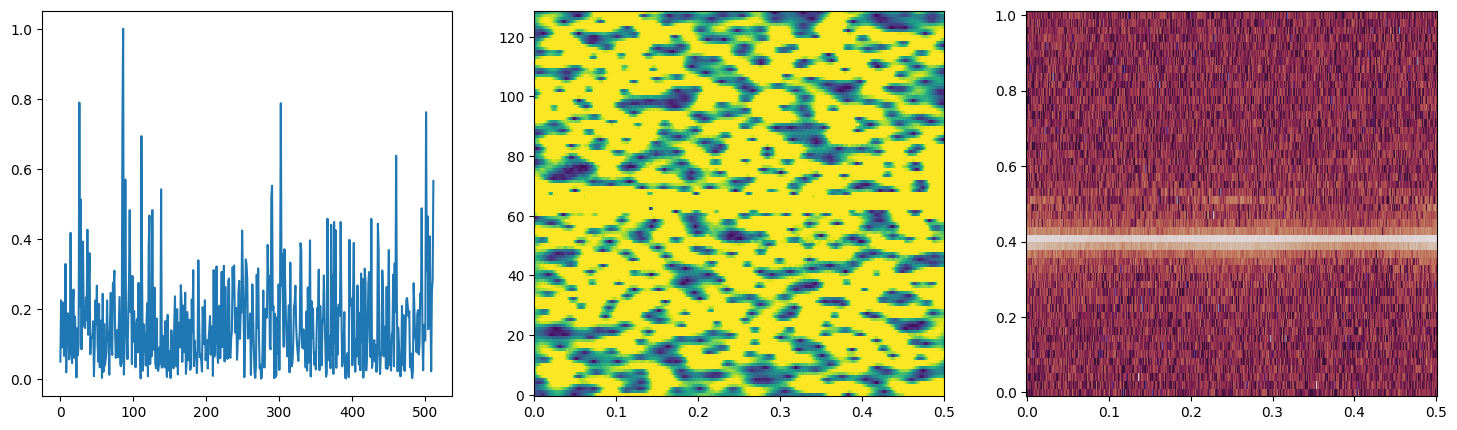

In [7]:
x,y = train_dataset.__getitem__(0)
print(f'label is {y}')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot((x[0]));
axes[1].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,128,128), x[1], vmax=1e-1);
hrrp = x[2]
axes[2].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,1,hrrp.shape[0]), hrrp, cmap='twilight');
# axes[2].set_ylim([0.4,0.6])

# Extract feature from m-D

In [243]:
class MatrixClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(MatrixClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(128 * 16 * 64, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# # 参数设置
num_classes  = 4  # 类别数
model = MatrixClassifierCNN(num_classes)
num_epochs = 200
learning_rate = 0.001

# # 初始化模型、损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [246]:
model.to(device)

def transfer_device(x,y):
    # Move inputs and labels to the device if they are not already
    if x.device != device:
        x = x.to(device)
    if y.device != device:
        y = y.to(device)
    return x,y

def tensor_process(x, y):
    x, y = transfer_device(x[1], y) # only use tfr.
    x = x.unsqueeze(1)
    return x, y 

for x,y in train_loader:
    x,y = tensor_process(x, y)
    print(x.shape, y.shape)
    y = model(x)
    break

torch.Size([32, 1, 128, 512]) torch.Size([32])


In [8]:
# model.to(device)

def train(dataloader, loss_fn, optimizer):
    total_acc, total_count, total_loss, = 0, 0, 0
    model.train()
    for x, y in dataloader:
        x, label = tensor_process(x, y)
        predicted_label = model(x)
        loss = loss_fn(predicted_label, label)
        # Back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_acc += (predicted_label.argmax(1) == label).sum().item()  # predict true
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def test(dataloader, loss_fn):
    model.eval()
    total_acc, total_count, total_loss, = 0, 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, label = tensor_process(x, y)
            predicted_label = model(x)
            loss = loss_fn(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def fit(epochs, train_dl, test_dl, loss_fn, optimizer):
    train_loss = [] 
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = train(train_dl, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, loss_fn)

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        tqdm.write(f'epoch:{epoch}, train_loss:{epoch_loss}, train_acc:{epoch_acc*100}%, test_loss:{epoch_test_loss}, test_acc:{epoch_test_acc*100}%.')
    
    return train_loss, test_loss, train_acc, test_acc

In [182]:
EPOCHS = 20
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, criterion, optimizer)

'''
20db
epoch:0, train_loss:0.5361727402210236, train_acc:76.75%, test_loss:0.5724768501520157, test_acc:73.5625%.
epoch:1, train_loss:0.4100787144899368, train_acc:83.22500000000001%, test_loss:0.4263982558250427, test_acc:82.75%.
epoch:2, train_loss:0.32595568054914476, train_acc:86.65%, test_loss:0.4626501056551933, test_acc:81.1875%.
epoch:3, train_loss:0.2652761281132698, train_acc:89.425%, test_loss:0.31523011684417723, test_acc:87.875%.
epoch:4, train_loss:0.19058642414212226, train_acc:92.675%, test_loss:0.2610070080310106, test_acc:87.9375%.
epoch:5, train_loss:0.14357985951006413, train_acc:94.375%, test_loss:0.2922845359146595, test_acc:89.9375%.
epoch:6, train_loss:0.11803647500276565, train_acc:95.775%, test_loss:0.2813598679378629, test_acc:89.1875%.
epoch:7, train_loss:0.08701506892964243, train_acc:96.875%, test_loss:0.2509671153873205, test_acc:90.8125%.
epoch:8, train_loss:0.062159811418503526, train_acc:97.52499999999999%, test_loss:0.32507621712982654, test_acc:90.5625%.
epoch:9, train_loss:0.061950461564585564, train_acc:97.82499999999999%, test_loss:0.2448848059028387, test_acc:91.9375%.
epoch:10, train_loss:0.06607791253365576, train_acc:97.65%, test_loss:0.24996702129021287, test_acc:92.625%.
epoch:11, train_loss:0.04958472577482462, train_acc:98.35000000000001%, test_loss:0.2555431672558188, test_acc:91.3125%.
epoch:12, train_loss:0.03547498930292204, train_acc:98.725%, test_loss:0.2384114591917023, test_acc:93.0625%.
epoch:13, train_loss:0.022726239684969188, train_acc:99.2%, test_loss:0.25002646012231705, test_acc:93.3125%.
epoch:14, train_loss:0.01605360435199691, train_acc:99.52499999999999%, test_loss:0.3190214814135106, test_acc:92.8125%.
epoch:15, train_loss:0.024676520756736865, train_acc:99.2%, test_loss:0.3496138797799358, test_acc:92.6875%.
epoch:16, train_loss:0.05449596782180015, train_acc:98.475%, test_loss:0.32528842411935327, test_acc:91.75%.
epoch:17, train_loss:0.037280162322800604, train_acc:98.625%, test_loss:0.3860971085727215, test_acc:91.4375%.
epoch:18, train_loss:0.021323606504010967, train_acc:99.2%, test_loss:0.31015715696965346, test_acc:92.8125%.
epoch:19, train_loss:0.013215573143446818, train_acc:99.52499999999999%, test_loss:0.2910488527081907, test_acc:92.9375%.
'''


'''0db
epoch:0, train_loss:1.1677154731750488, train_acc:41.825%, test_loss:0.7945557963848114, test_acc:63.24999999999999%.
epoch:1, train_loss:0.7328069653511048, train_acc:64.85%, test_loss:0.6864826798439025, test_acc:69.375%.
epoch:2, train_loss:0.6136363656520843, train_acc:71.89999999999999%, test_loss:0.7384293639659881, test_acc:69.6875%.
epoch:3, train_loss:0.5608197798728943, train_acc:74.275%, test_loss:0.6995599156618119, test_acc:71.125%.
epoch:4, train_loss:0.48157934856414797, train_acc:78.60000000000001%, test_loss:0.6201447814702987, test_acc:73.125%.
epoch:5, train_loss:0.43453579115867613, train_acc:81.69999999999999%, test_loss:0.5445114356279374, test_acc:76.25%.
epoch:6, train_loss:0.39391904389858245, train_acc:83.39999999999999%, test_loss:0.7232418456673622, test_acc:73.8125%.
epoch:7, train_loss:0.3484359735250473, train_acc:85.32499999999999%, test_loss:0.5734537315368652, test_acc:78.6875%.
epoch:8, train_loss:0.31052896082401277, train_acc:86.97500000000001%, test_loss:0.6308506566286087, test_acc:78.1875%.
epoch:9, train_loss:0.2854994108080864, train_acc:87.75%, test_loss:0.6370622968673706, test_acc:78.1875%.
epoch:10, train_loss:0.2638493672013283, train_acc:89.075%, test_loss:0.700521724820137, test_acc:78.4375%.
epoch:11, train_loss:0.25144448727369306, train_acc:88.925%, test_loss:0.7223253360390663, test_acc:78.0625%.
epoch:12, train_loss:0.22726679703593253, train_acc:90.075%, test_loss:0.7072244426608085, test_acc:78.75%.
epoch:13, train_loss:0.2214024069905281, train_acc:89.875%, test_loss:0.7433808526396751, test_acc:79.0%.
epoch:14, train_loss:0.21092978328466416, train_acc:90.875%, test_loss:0.7446960575878621, test_acc:77.625%.
epoch:15, train_loss:0.18848138839006423, train_acc:91.5%, test_loss:0.8374516010284424, test_acc:79.5%.
epoch:16, train_loss:0.1961166200786829, train_acc:92.07499999999999%, test_loss:0.8013652095198631, test_acc:79.8125%.
epoch:17, train_loss:0.17896248212456703, train_acc:92.4%, test_loss:0.8126708772778511, test_acc:78.5%.
epoch:18, train_loss:0.18330337837338448, train_acc:92.05%, test_loss:0.8259307014942169, test_acc:79.6875%.
epoch:19, train_loss:0.19361626493930817, train_acc:92.05%, test_loss:0.7432087349891663, test_acc:80.0%.
'''

epoch:0, train_loss:1.1677154731750488, train_acc:41.825%, test_loss:0.7945557963848114, test_acc:63.24999999999999%.
epoch:1, train_loss:0.7328069653511048, train_acc:64.85%, test_loss:0.6864826798439025, test_acc:69.375%.
epoch:2, train_loss:0.6136363656520843, train_acc:71.89999999999999%, test_loss:0.7384293639659881, test_acc:69.6875%.
epoch:3, train_loss:0.5608197798728943, train_acc:74.275%, test_loss:0.6995599156618119, test_acc:71.125%.
epoch:4, train_loss:0.48157934856414797, train_acc:78.60000000000001%, test_loss:0.6201447814702987, test_acc:73.125%.
epoch:5, train_loss:0.43453579115867613, train_acc:81.69999999999999%, test_loss:0.5445114356279374, test_acc:76.25%.
epoch:6, train_loss:0.39391904389858245, train_acc:83.39999999999999%, test_loss:0.7232418456673622, test_acc:73.8125%.
epoch:7, train_loss:0.3484359735250473, train_acc:85.32499999999999%, test_loss:0.5734537315368652, test_acc:78.6875%.
epoch:8, train_loss:0.31052896082401277, train_acc:86.97500000000001%, tes

'\n20db\nepoch:0, train_loss:0.5361727402210236, train_acc:76.75%, test_loss:0.5724768501520157, test_acc:73.5625%.\nepoch:1, train_loss:0.4100787144899368, train_acc:83.22500000000001%, test_loss:0.4263982558250427, test_acc:82.75%.\nepoch:2, train_loss:0.32595568054914476, train_acc:86.65%, test_loss:0.4626501056551933, test_acc:81.1875%.\nepoch:3, train_loss:0.2652761281132698, train_acc:89.425%, test_loss:0.31523011684417723, test_acc:87.875%.\nepoch:4, train_loss:0.19058642414212226, train_acc:92.675%, test_loss:0.2610070080310106, test_acc:87.9375%.\nepoch:5, train_loss:0.14357985951006413, train_acc:94.375%, test_loss:0.2922845359146595, test_acc:89.9375%.\nepoch:6, train_loss:0.11803647500276565, train_acc:95.775%, test_loss:0.2813598679378629, test_acc:89.1875%.\nepoch:7, train_loss:0.08701506892964243, train_acc:96.875%, test_loss:0.2509671153873205, test_acc:90.8125%.\nepoch:8, train_loss:0.062159811418503526, train_acc:97.52499999999999%, test_loss:0.32507621712982654, test

# Extract feature from hrrp

In [9]:
class MatrixClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(MatrixClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(128 * 6 * 64, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# # 参数设置
num_classes  = 4  # 类别数
model = MatrixClassifierCNN(num_classes)
num_epochs = 200
learning_rate = 0.001

# # 初始化模型、损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
model.to(device)

def transfer_device(x,y):
    # Move inputs and labels to the device if they are not already
    if x.device != device:
        x = x.to(device)
    if y.device != device:
        y = y.to(device)
    return x,y

def tensor_process(x, y):
    x, y = transfer_device(x[2], y) # only use tfr.
    x = x.unsqueeze(1)
    return x, y 

for x,y in train_loader:
    x,y = tensor_process(x, y)
    print(x.shape, y.shape)
    y = model(x)
    print(y.shape)
    break

torch.Size([32, 1, 50, 512]) torch.Size([32])
torch.Size([32, 4])


In [11]:
EPOCHS = 20
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, criterion, optimizer)

'''20db without padding HH
epoch:0, train_loss:1.3934904403686523, train_acc:26.75%, test_loss:1.3866887927055358, test_acc:25.0%.
epoch:1, train_loss:1.299120114326477, train_acc:35.475%, test_loss:1.1825577330589294, test_acc:42.875%.
epoch:2, train_loss:0.8195709300041198, train_acc:53.400000000000006%, test_loss:0.7182581031322479, test_acc:55.43749999999999%.
epoch:3, train_loss:0.702967746257782, train_acc:58.9%, test_loss:0.6733141994476318, test_acc:61.12499999999999%.
epoch:4, train_loss:0.6499581553936005, train_acc:64.025%, test_loss:0.6815271413326264, test_acc:57.9375%.
epoch:5, train_loss:0.5695804851055145, train_acc:71.025%, test_loss:0.6422406280040741, test_acc:62.9375%.
epoch:6, train_loss:0.5963453557491303, train_acc:69.85%, test_loss:0.6143610763549805, test_acc:65.875%.
epoch:7, train_loss:0.49757040143013, train_acc:75.625%, test_loss:0.5656358498334885, test_acc:72.0%.
epoch:8, train_loss:0.46273528957366944, train_acc:77.85%, test_loss:0.5426398408412934, test_acc:71.4375%.
epoch:9, train_loss:0.43169426190853116, train_acc:79.75%, test_loss:0.5491626912355423, test_acc:72.4375%.
epoch:10, train_loss:0.4172542071342468, train_acc:79.05%, test_loss:0.49199013113975526, test_acc:75.25%.
epoch:11, train_loss:0.39022954273223875, train_acc:82.27499999999999%, test_loss:0.5043667322397232, test_acc:74.0%.
epoch:12, train_loss:0.35137744855880737, train_acc:83.975%, test_loss:0.4626850324869156, test_acc:77.0%.
epoch:13, train_loss:0.3184644611477852, train_acc:85.425%, test_loss:0.42808728367090226, test_acc:77.875%.
epoch:14, train_loss:0.30327063089609146, train_acc:86.7%, test_loss:0.5154253762960433, test_acc:74.5625%.
epoch:15, train_loss:0.3121601244211197, train_acc:85.425%, test_loss:0.49522600442171094, test_acc:77.375%.
epoch:16, train_loss:0.27373993408679964, train_acc:87.6%, test_loss:0.4365496897697449, test_acc:78.4375%.
epoch:17, train_loss:0.2542345833182335, train_acc:88.5%, test_loss:0.4320670455694199, test_acc:79.125%.
epoch:18, train_loss:0.2426743329167366, train_acc:89.35%, test_loss:0.3791580015420914, test_acc:81.4375%.
epoch:19, train_loss:0.26758016169071197, train_acc:88.05%, test_loss:0.4402558943629265, test_acc:79.125%.
'''

'''20db padding 512 with cut off [192,320] HH
epoch:0, train_loss:1.3956012229919434, train_acc:27.825%, test_loss:1.4204877090454102, test_acc:25.0%.
epoch:1, train_loss:1.3181830940246582, train_acc:34.175%, test_loss:1.190326955318451, test_acc:40.875%.
epoch:2, train_loss:1.1118818364143372, train_acc:44.625%, test_loss:0.8665825271606445, test_acc:50.18749999999999%.
epoch:3, train_loss:0.726324149608612, train_acc:61.5%, test_loss:0.655928835272789, test_acc:62.9375%.
epoch:4, train_loss:0.5761403017044068, train_acc:71.025%, test_loss:0.5913874810934067, test_acc:69.75%.
epoch:5, train_loss:0.5147082219123841, train_acc:75.225%, test_loss:0.5745633882284165, test_acc:69.625%.
epoch:6, train_loss:0.4315277540683746, train_acc:79.625%, test_loss:0.5729498845338822, test_acc:71.75%.
epoch:7, train_loss:0.4105433501005173, train_acc:80.05%, test_loss:0.509456724524498, test_acc:73.875%.
epoch:8, train_loss:0.3723720670938492, train_acc:82.475%, test_loss:0.4627795559167862, test_acc:74.625%.
epoch:9, train_loss:0.34594097900390625, train_acc:82.825%, test_loss:0.5278698897361755, test_acc:72.4375%.
epoch:10, train_loss:0.33053850507736204, train_acc:84.25%, test_loss:0.4593976724147797, test_acc:74.0625%.
epoch:11, train_loss:0.29890548342466355, train_acc:85.05%, test_loss:0.41394814431667326, test_acc:79.125%.
epoch:12, train_loss:0.3260794197320938, train_acc:84.075%, test_loss:0.45693682312965395, test_acc:76.0625%.
epoch:13, train_loss:0.28949908208847047, train_acc:86.275%, test_loss:0.40345485031604766, test_acc:79.8125%.
epoch:14, train_loss:0.27458857810497284, train_acc:86.575%, test_loss:0.41423054367303846, test_acc:77.9375%.
epoch:15, train_loss:0.29067342150211334, train_acc:86.225%, test_loss:0.4163625568151474, test_acc:77.875%.
epoch:16, train_loss:0.25129741191864013, train_acc:87.64999999999999%, test_loss:0.41282847404479983, test_acc:78.6875%.
epoch:17, train_loss:0.24358234357833863, train_acc:88.6%, test_loss:0.4442016437649727, test_acc:77.8125%.
epoch:18, train_loss:0.22788886946439743, train_acc:89.375%, test_loss:0.39553733080625536, test_acc:80.4375%.
epoch:19, train_loss:0.22443655103445054, train_acc:89.325%, test_loss:0.4143620654940605, test_acc:79.25%.
'''

'''20db HH withoutpadding [75:125]
epoch:0, train_loss:1.3891620025634766, train_acc:25.900000000000002%, test_loss:1.3883762979507446, test_acc:25.0%.
epoch:1, train_loss:1.3721016473770142, train_acc:29.075%, test_loss:1.1708864974975586, test_acc:42.6875%.
epoch:2, train_loss:0.5816273769140243, train_acc:72.075%, test_loss:0.6612479907274246, test_acc:66.1875%.
epoch:3, train_loss:0.09062675330229103, train_acc:97.02499999999999%, test_loss:0.010214722107630223, test_acc:99.875%.
epoch:4, train_loss:0.0334429379561916, train_acc:98.9%, test_loss:0.10952538250014186, test_acc:95.5%.
epoch:5, train_loss:0.012618616060353815, train_acc:99.7%, test_loss:0.006172741976333782, test_acc:99.9375%.
epoch:6, train_loss:0.0023461935658124276, train_acc:99.97500000000001%, test_loss:0.0023586422731750644, test_acc:99.9375%.
epoch:7, train_loss:0.00043218782992335037, train_acc:100.0%, test_loss:0.0017026499725761824, test_acc:99.9375%.
epoch:8, train_loss:0.00034778524754801765, train_acc:100.0%, test_loss:0.0016982098248263355, test_acc:100.0%.
epoch:9, train_loss:0.00042072154383640737, train_acc:100.0%, test_loss:0.001638579812279204, test_acc:99.9375%.
epoch:10, train_loss:0.0002088995571975829, train_acc:100.0%, test_loss:0.001086929126176983, test_acc:100.0%.
epoch:11, train_loss:0.00017546973301796242, train_acc:100.0%, test_loss:0.0011007205002533738, test_acc:99.9375%.
epoch:12, train_loss:0.00029299412145337555, train_acc:100.0%, test_loss:0.003910352222701477, test_acc:99.875%.
epoch:13, train_loss:0.00012681609356513944, train_acc:100.0%, test_loss:0.001145473101278185, test_acc:99.9375%.
epoch:14, train_loss:0.00013198678328626555, train_acc:100.0%, test_loss:0.0016040657897610799, test_acc:99.9375%.
'''

'''0db VH withoutpadding [75:125]
epoch:0, train_loss:1.390678463935852, train_acc:25.275%, test_loss:1.3884007000923158, test_acc:25.0%.
epoch:1, train_loss:1.3856113328933717, train_acc:26.450000000000003%, test_loss:1.3883520483970642, test_acc:25.0%.
epoch:2, train_loss:1.3850253763198852, train_acc:27.400000000000002%, test_loss:1.3880735111236573, test_acc:25.0%.
epoch:3, train_loss:1.3841670341491699, train_acc:27.400000000000002%, test_loss:1.3884850573539733, test_acc:25.0%.
epoch:4, train_loss:1.3838616981506349, train_acc:27.400000000000002%, test_loss:1.3876576447486877, test_acc:25.0%.
epoch:5, train_loss:0.8929180362224579, train_acc:55.35%, test_loss:0.6021375477313995, test_acc:72.4375%.
epoch:6, train_loss:0.3339630727171898, train_acc:86.375%, test_loss:0.27332621037960053, test_acc:89.0%.
epoch:7, train_loss:0.16963386103510858, train_acc:93.77499999999999%, test_loss:0.14494347020983697, test_acc:95.5%.
epoch:8, train_loss:0.12172422252595425, train_acc:95.325%, test_loss:0.26736720964312555, test_acc:88.9375%.
epoch:9, train_loss:0.0923322913646698, train_acc:96.45%, test_loss:0.1396795248426497, test_acc:95.1875%.
epoch:10, train_loss:0.0713413777537644, train_acc:97.52499999999999%, test_loss:0.07047793230041861, test_acc:97.3125%.
epoch:11, train_loss:0.0670858167372644, train_acc:97.475%, test_loss:0.10641584038734436, test_acc:95.75%.
epoch:12, train_loss:0.05919904024899006, train_acc:97.95%, test_loss:0.04062451528850943, test_acc:99.0%.
epoch:13, train_loss:0.03568907655635849, train_acc:98.7%, test_loss:0.05144307252019644, test_acc:98.5%.
epoch:14, train_loss:0.03256837562564761, train_acc:98.85000000000001%, test_loss:0.04098741049412638, test_acc:98.6875%.
epoch:15, train_loss:0.020545100344810635, train_acc:99.4%, test_loss:0.06417559450492263, test_acc:97.9375%.
epoch:16, train_loss:0.019669214494293555, train_acc:99.325%, test_loss:0.09762073308229446, test_acc:95.8125%.
epoch:17, train_loss:0.039865849692374465, train_acc:98.55000000000001%, test_loss:0.20896372202783822, test_acc:92.625%.
epoch:18, train_loss:0.031368359220214186, train_acc:98.875%, test_loss:0.05303854936850257, test_acc:98.625%.
epoch:19, train_loss:0.022097143237479033, train_acc:99.2%, test_loss:0.030883647084701805, test_acc:99.25%.
'''

epoch:0, train_loss:1.4036113538742065, train_acc:26.200000000000003%, test_loss:1.386565136909485, test_acc:25.0%.
epoch:1, train_loss:1.3854910163879395, train_acc:26.525%, test_loss:1.3841981673240662, test_acc:25.0%.
epoch:2, train_loss:1.3851051025390626, train_acc:26.1%, test_loss:1.3898958015441893, test_acc:25.0%.
epoch:3, train_loss:1.3841549282073975, train_acc:27.775%, test_loss:1.387065625190735, test_acc:25.0%.
epoch:4, train_loss:1.3851719560623168, train_acc:26.75%, test_loss:1.384963297843933, test_acc:25.0%.


KeyboardInterrupt: 